# Random Forests for Kaggle's Titanic Data Set

---

Kaggle is a great site for data science and machine learning enthusiasts to find interesting problems to tackle. For those exploring machine learning and its implementations, the [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic) is arguably one of the most popular challenges to try out.

In this notebook, I take a shot at the Titanic challenge, aiming to improve the [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification) of the [suggested random forest model]() that was provided by Kaggle.

Outline of this notebook:
>1. Data description and exploration
    - 1.1 Load data
    - 1.2 Data exploration
    <br><br>
2. Data wrangling and feature engineering
    - 2.1 Creating `Title` from `Name`
    - 2.2 Imputing `Age`
    - 2.3 Imputing `Embarked`, `Fare` and `Cabin`
    - 2.4 Creating `FamSize`
    - 2.5 `Ticket`
    - 2.6 One-hot encoding
    <br><br>
3. Modeling
    - 3.1 Create train-validation split using stratified k-fold cross validation
    - 3.2 Hyperparameter tuning
    - 3.3 Prediction on `X_test` and submission

In [1]:
# General libraries required for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries needed for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Miscellaneous
import warnings
warnings.simplefilter("ignore")

% matplotlib inline

---
### 1. Data description and exploration

#### 1.1 Load data

The relevant data sets can be found [here](https://www.kaggle.com/c/titanic/data), provided by Kaggle. There are two data sets provided, `train.csv` and `test.csv`. I will merge both the data sets into a single, collective dataframe `total_data_df` in order to have to only conduct the data wrangling only once.

In [2]:
# Load training and testing data
train_df = pd.read_csv("Titanic_data/train.csv")
test_df = pd.read_csv("Titanic_data/test.csv")

# Merge `train_data_df` and `test_data_df`
total_df = pd.concat(objs = [train_df, test_df], axis = 0, sort = False).reset_index(drop = True)

# Create index to slice dataframe back into train and test set
train_idx = len(train_df)

# Create PassengerId from test set
passengerId = test_df["PassengerId"]

# Create dataframe to describe each variable
variable_list = ['survival', 'pclass', 'sex', 'Age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked']
definition_list = ['Survival', 'Ticket', 'Sex', 'Age in years', '# of siblings / spouses aboard the Titanic', '# of parents / children aboard the Titanic', 'Ticket number', 'Passenger fare', 'Cabin number', 'Port of embarkation']
key_list = ['0 = No, 1 = Yes', '1 = 1st, 2 = 2nd, 3 = 3rd', '', '', '', '', '', '', '', 'C = Cherbourg, Q = Queenstown, S = Southampton']
variable_tuple = zip(variable_list, definition_list, key_list)
variable_description_df = pd.DataFrame(variable_tuple, columns = ['Variable', 'Definition', 'Key'])

variable_description_df

,Variable,Definition,Key
0,survival,Survival,"0 = No, 1 = Yes"
1,pclass,Ticket,"1 = 1st, 2 = 2nd, 3 = 3rd"
2,sex,Sex,
3,Age,Age in years,
4,sibsp,# of siblings / spouses aboard the Titanic,
5,parch,# of parents / children aboard the Titanic,
6,ticket,Ticket number,
7,fare,Passenger fare,
8,cabin,Cabin number,
9,embarked,Port of embarkation,"C = Cherbourg, Q = Queenstown, S = Southampton"


In [3]:
total_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### 1.2 Data exploration

It is my common practice to first visualise the `NaN` values in a given data set. This gives me a rough feel of how 'ready' the data set is to be fed into any model.

Below is a heatmap of the entire `total_data_df` dataframe, where dark maroon bars represent any cells in the dataframe that are `NaN` values. I've transposed the dataframe to get a horizontal plot. There is a sizable number of missing values in the `Age` column and almost all the values for `Cabin` are missing. `Fare` and `Embarked` have a trivial number of missing values.

Also, note that the bottom part of the `total_data_df` dataframe has missing values in the `Survived` column. This missing portion of the dataframe corresponds to the `test.csv` dataset and the missing `Survived` values are exactly what we will be trying to predict.

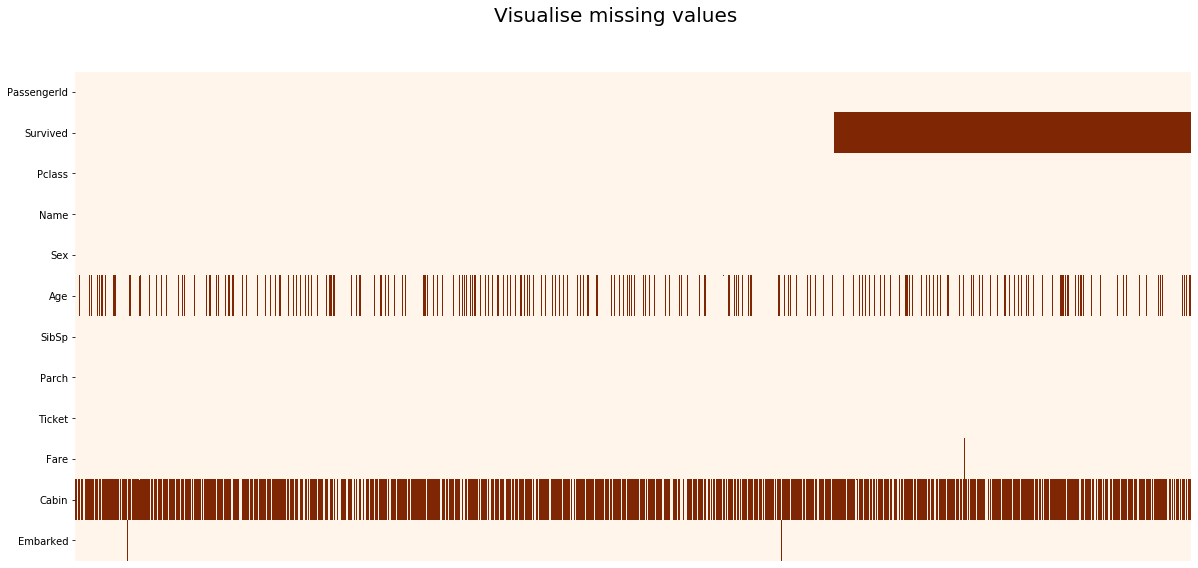

In [4]:
# Visualise NaN occurances
fig1 = plt.figure(figsize = (20,9))
fig1.suptitle("Visualise missing values", fontsize = 20)
sns.heatmap(total_df.isnull().transpose(), cmap = "Oranges", xticklabels = False, cbar = False)

Here, I visualise the survival rate across each of the predictors to get a feel their relationships.

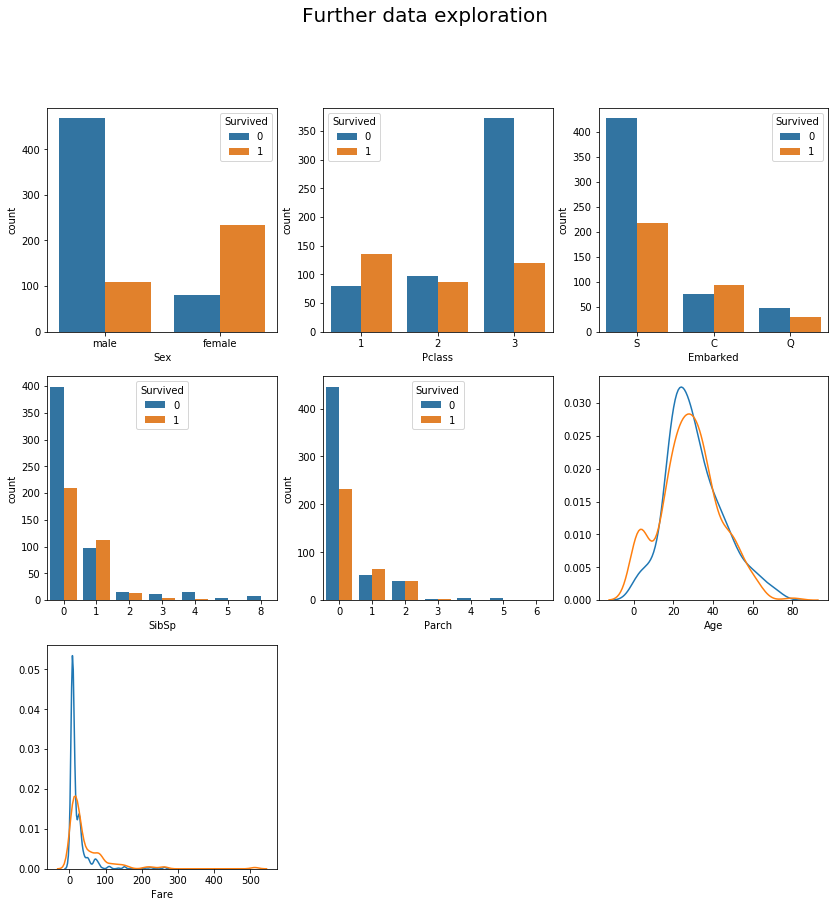

In [5]:
fig2 = plt.figure(figsize = (14, 14))
fig2.suptitle("Further data exploration", fontsize = 20)


ax_sex = fig2.add_subplot(3, 3, 1)
sns.countplot(ax = ax_sex, x = "Sex", hue = "Survived", data = train_df)

ax_pclass = fig2.add_subplot(3, 3, 2)
sns.countplot(ax = ax_pclass, x = "Pclass", hue = "Survived", data = train_df)

ax_embarked = fig2.add_subplot(3, 3, 3)
sns.countplot(ax = ax_embarked, x = "Embarked", hue = "Survived", data = train_df)

ax_sibsp = fig2.add_subplot(3, 3, 4)
sns.countplot(ax = ax_sibsp, x = "SibSp", hue = "Survived", data = train_df)

ax_parch = fig2.add_subplot(3, 3, 5)
sns.countplot(ax = ax_parch, x = "Parch", hue = "Survived", data = train_df)

ax_age = fig2.add_subplot(3, 3, 6)
sns.distplot(train_df[train_df["Survived"] == 0]["Age"].dropna(), hist = False)
sns.distplot(train_df[train_df["Survived"] == 1]["Age"].dropna(), hist = False)

ax_age = fig2.add_subplot(3, 3, 7)
sns.distplot(train_df[train_df["Survived"] == 0]["Fare"].dropna(), hist = False)
sns.distplot(train_df[train_df["Survived"] == 1]["Fare"].dropna(), hist = False)


Some general relatioships that we can infer based on the visuals:

- __*Survival rate vs. `sex`*__: Females have a higher survival rate that males.

- __*Survival rate vs. `Pclass`*__: Survival rate decreases as we move from 1st class to 2nd class to 3rd class.

- __*Survival rate vs. `SibSp`*__: Survival rate generally decreases as the number of siblings onboard increases.

- __*Survival rate vs. `Parch`*__: Survival rate generally decreases as the number of parents and children onboard increases.

- __*Survival rate vs. `Age`*__: Children aged between 0 - 18 y/o have more survivors that deaths, while adults ages between 18 - around 40y/o have more deaths than survivors.

- __*Survival rate vs. `Fare`*__: Those that paid upwards of $100 expereinced more survivors than deaths.

---

### 2. Data wrangling and feature engineering

#### 2.1 Creating `Title` from `Name`

First, I will make use of the `Name` feature the honorific of each passenger to create a new `Title` feature. `Title` will give us more information about a passenger's socioeconomic status, which might be a significant predictor for a passenger's chance of survival. 

The titles will be normalised by grouping various titles together based on the `normalised_titles` dictionary. 

We will end up with the following 5 titles:
- `Mr`
- `Miss`
- `Mrs`
- `Master`
- `Rare`

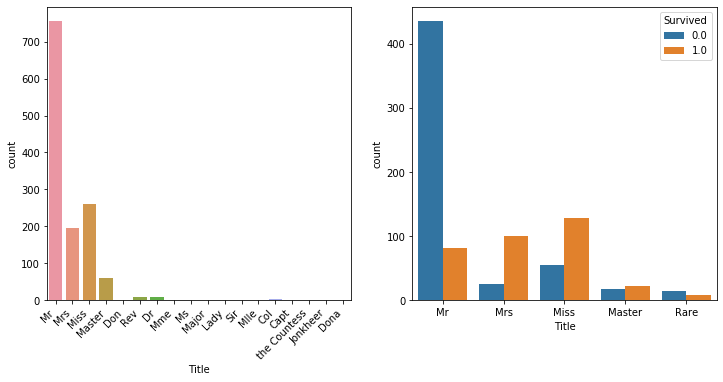

In [6]:
# Create new column called `Title`
total_df["Title"] = total_df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Get unique `Titles`
unique_title = total_df["Title"].unique()

# Visualise unique `Titles`
fig_title = plt.figure(figsize = (12, 6))
ax_title_before = fig_title.add_subplot(1, 2, 1)
sns.countplot(ax = ax_title_before, x = "Title", data = total_df)
fig_title.autofmt_xdate(rotation = 45)

# Normalise "Titles"
normalised_titles = {
    "Jonkheer": "Rare",
    "Don": "Rare",
    "Dona": "Rare", 
    "Sir" : "Rare",
    "Lady" : "Rare",
    "the Countess":"Rare",
    "Capt": "Rare",
    "Col": "Rare",
    "Major": "Rare",
    "Dr": "Rare",
    "Rev": "Rare",
    "Mme": "Mrs",
    "Ms": "Mrs",
    "Mrs" : "Mrs",
    "Mlle": "Miss",
    "Mr" : "Mr",
    "Miss" : "Miss",
    "Master" : "Master",
}

# Map normlaised "Titles" to "Title" column
total_df["Title"] = total_df["Title"].map(normalised_titles)

# Drop `Name` column
total_df.drop(["Name"], axis = 1, inplace = True)

# Visualise the normalised `Titles`
ax_title_after = fig_title.add_subplot(1, 2, 2)
sns.countplot(ax = ax_title_after, x = "Title", hue = "Survived", data = total_df)

It is interesting to note that "Women and children first" (`Master` identifies males 14 y/o or younger) and passengers with `Rare` titles have a higher chance to survive as compared to males.

#### 2.2 Imputing `Age`

Since we see that there are subpopulations that have a higher chance of survival (children aged between 0 - 18y/o), it is preferable to keep the `Age` feature and impute the missing values.

Instead of imputing `Age` with its mean or median, I think it might be more accurate to impute using the median `Age` of the groups that they belong to. Hence, I need to decide which features I should be using to bin the passengers. 

For numeric features, I should use features that are highly correlated with `Age`. From the correlation matrix below, `Age` is most correlated with `SibSp`, `Parch` and `Pclass`.

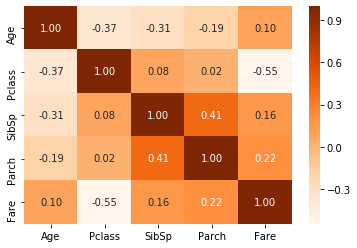

In [7]:
# Correlation matrix between numerical values
corr_matrix = sns.heatmap(train_df[["Age", "Pclass", "SibSp", "Parch", "Fare"]].corr(), annot = True, fmt = ".2f", cmap = "Oranges")

Hence, we can divide the passengers into subgroups based on the following features:
- `Pclass`
- `SibSp`
- `Parch`
- `Title`

For example, if a passenger with missing `Age` value has no siblings, no parents/children on board, took the 1st passenger class and had a title of Miss, then we would impute her `Age` with the median `Age` of that group, i.e. `32.0`.

In [8]:
# Group by `Sex`, `Pclass`, `Title`
grouped_df = total_df.groupby(["SibSp", "Parch", "Pclass", "Title"])

print(grouped_df.Age.median())

# Impute missing `Age` data using grouped median
total_df["Age"] = grouped_df.Age.apply(lambda x: x.fillna(x.median()))

total_df.info()

SibSp  Parch  Pclass  Title 
0      0      1       Miss      32.0
                      Mr        42.0
                      Mrs       54.0
                      Rare      45.0
              2       Miss      28.0
                                ... 
5      2      3       Miss      13.0
                      Mr        14.0
8      2      3       Master    14.5
                      Miss       NaN
                      Mr         NaN
Name: Age, Length: 125, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Sex            1309 non-null object
Age            1299 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Title          1309 non-n

After imputing `Age`, we see that there are still 10 missing `Age` variables. These are variables of passengers who belong to subgroups whose passengers are all missing the `Age` variable themselves (hence median of those subgroups are still `NaN`). We will impute the remaining 10 missing variables with the median of their respective `Title`s.

In [9]:
# Group again by `Title`
grouped_df2 = total_df.groupby(["Title"])

# Impute remaining 10 missing `Age` variables
total_df["Age"] = grouped_df2.Age.apply(lambda x: x.fillna(x.median()))

total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Title          1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


#### 2.3 Imputing `Embarked`, `Fare` and `Cabin`

For `Fare`, since there is only 1 missing value, I will impute it with the median value from the data set.

For `Embarked`, since there are aonly 2 missing values, I will impute it with the highest occuring (mode) point of embarkment.

For `Cabin`, since majority of the values are missing, I will impute it with a new variable `Unk` to indicate that it is unknown.

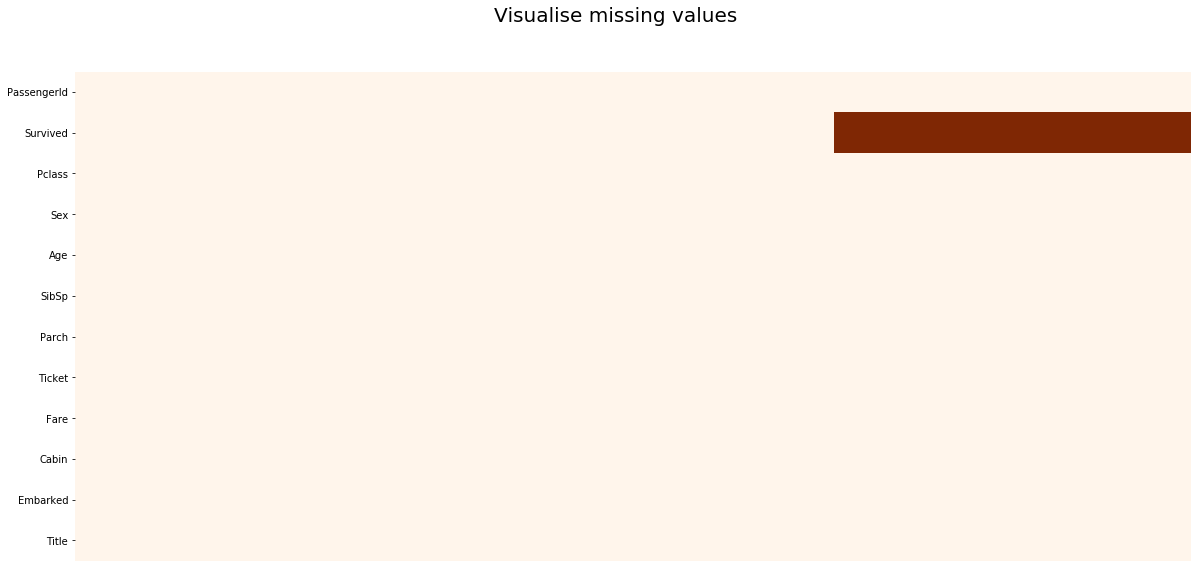

In [10]:
# Impute `Fare` with median fare
total_df["Fare"] = total_df["Fare"].fillna(total_df["Fare"].median())

# Impute `Embarkment` with mode
most_embarked = total_df["Embarked"].value_counts().index[0]
total_df["Embarked"] = total_df["Embarked"].fillna(most_embarked)

# Convert "Cabin" to just its first letter
for row in total_df.itertuples():
    if not pd.isna(row.Cabin):
        total_df.at[row.Index, "Cabin"] = row.Cabin[0]
# Impute `Cabin` with `U`
total_df["Cabin"] = total_df["Cabin"].fillna("Unk")


# Visualise NaN occurances after imputing missing values
fig1 = plt.figure(figsize = (20,9))
fig1.suptitle("Visualise missing values", fontsize = 20)
sns.heatmap(total_df.isnull().transpose(), cmap = "Oranges", xticklabels = False, cbar = False)

Now, all the NaN values have been imputed and we are only left with the missing `Survived` values that we need to predict.

#### 2.4 Creating `FamSize`

We can imagine that passengers with larger families have a lower chance of survival, since they might be searching for family members or having a hard time securing a space on the life boat.

We see that families of sizes 0 to 4 have a higher chance of survival than larger families of sizes 5 to 11.

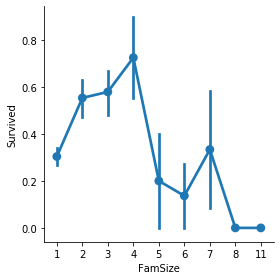

In [11]:
# Create `FamSize`
total_df["FamSize"] = total_df["SibSp"] + total_df["Parch"] + 1

# Visualise `FamSize` and the rate of survival.
FamSize_plot = sns.factorplot(x = "FamSize", y = "Survived", data = total_df)

#### 2.5 `Ticket`

The format of the ticket numbers is a follows:
- [Optional string, we call `TixPre`] (space) [numbers, we call `TixNum`]
- e.g PC 17599
- e.g. A/5 21171 - In this case, thee string `A` is the `TixPre`


We extract `TixPre` from `Ticket` - if there is no prefix, then `TixPre = NoPrefix`. 



In [12]:
TixPre_list = []

# Loop and extract `TixPre`
for i in total_df["Ticket"].tolist():
    if not i.isdigit():
        TixPre_list.append(i.replace("/", "").replace(".", "").split(" ")[0])
    else:
        TixPre_list.append("NoPrefix")
        
# Map `TixPre` back to `Ticket` column
total_df["Ticket"] = TixPre_list

#### 2.6 One-hot encoding

Now that we have all our features cleaned and engineered, we will one-hot encode all the categorical features.

In [13]:
# Convert Pclass from 1, 2, 3 to 1st, 2nd, 3rd
Pclass_dict = {1:"1st", 2:"2nd", 3:"3rd"}
total_df["Pclass"] = total_df["Pclass"].map(Pclass_dict)

# One-hot encode categorical variables
dummies = pd.get_dummies(total_df[["Pclass", "Sex", "Embarked", "Cabin", "Title", "Ticket"]])
total_df.drop(["Pclass", "Sex", "Embarked", "Cabin", "Title", "Ticket"], axis = 1, inplace = True)
total_df = pd.concat([total_df, dummies], axis = 1)

# Drop `PassengerId`
total_df.drop(["PassengerId"], axis = 1, inplace = True)

This is how our final dataframe looks like:

In [14]:
total_df.info()
total_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 65 columns):
Survived           891 non-null float64
Age                1309 non-null float64
SibSp              1309 non-null int64
Parch              1309 non-null int64
Fare               1309 non-null float64
FamSize            1309 non-null int64
Pclass_1st         1309 non-null uint8
Pclass_2nd         1309 non-null uint8
Pclass_3rd         1309 non-null uint8
Sex_female         1309 non-null uint8
Sex_male           1309 non-null uint8
Embarked_C         1309 non-null uint8
Embarked_Q         1309 non-null uint8
Embarked_S         1309 non-null uint8
Cabin_A            1309 non-null uint8
Cabin_B            1309 non-null uint8
Cabin_C            1309 non-null uint8
Cabin_D            1309 non-null uint8
Cabin_E            1309 non-null uint8
Cabin_F            1309 non-null uint8
Cabin_G            1309 non-null uint8
Cabin_T            1309 non-null uint8
Cabin_Unk          1309 non-nu

,Survived,Age,SibSp,Parch,Fare,FamSize,Pclass_1st,Pclass_2nd,Pclass_3rd,Sex_female,...,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP
0,0.0,22.0,1,0,7.2500,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,38.0,1,0,71.2833,2,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1.0,26.0,0,0,7.9250,1,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
3,1.0,35.0,1,0,53.1000,2,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.0,35.0,0,0,8.0500,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


---

### 3. Modeling

#### 3.1 Create train-validation split using [stratified k-fold cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)

To avoid confusion with the actual `X_test` that we are supposed to do the prediction on, I will name the splits of `X_train` _train_ and _validation_ sets.

I will set `k = 10`. Typically, given the considerations of bias-variance trade-off associated with the choice of k in k-fold cross validation, k = 5 or k = 10 is used as these values have been shown empirically to suffer neither from excessively high bias nor very high variance. This means that `X_train` will be split into 10 groups of approximately the same size. Since `X_train` has 891 rows, each group will contain approximately 891 / 10 = ~89 rows.

I've visualised this stratified 10-fold cross validation in the plot below, where the dark green cells represents the indices of the rows in `X_train` that is used for the validation set in each fold.

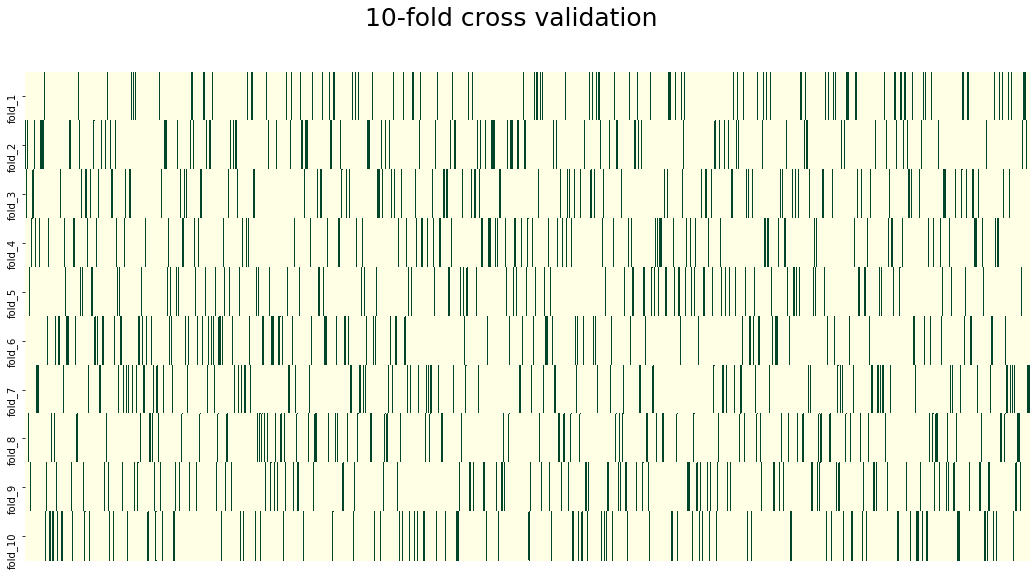

In [15]:
# Split the `total_df` back into the original train and test sets

train_new_df = total_df[ :train_idx]
train_new_df['Survived'] = train_new_df['Survived'].astype(int)
test_new_df = total_df[train_idx: ]
test_new_df.drop(["Survived"], axis = 1, inplace = True)

X_train = train_new_df.drop(["Survived"], axis = 1, inplace = False)
Y_train = train_new_df["Survived"]

X_test = test_new_df

# Define random seed to make results deterministic
RSEED = 999

# Instantiate cross validation
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = RSEED)

# Visualise splits of `X_train` into train and validation sets
col_names = ["fold_{}".format(i) for i in range(1, 11)]
validate_idx_df = pd.DataFrame(index = [i for i in range(0, len(X_train))], columns = col_names)

i = 0
for train, validate in kfold.split(X = X_train, y = Y_train):
    col = col_names[i]
    for idx in validate:
        validate_idx_df.at[idx, col] = 1
    i += 1
    
fig_validate = plt.figure(figsize = (18, 9))
fig_validate.suptitle("10-fold cross validation", fontsize = 25)
sns.heatmap(validate_idx_df.notnull().transpose(), cmap = "YlGn", xticklabels = False, cbar = False)

#### 3.2 Hyperparameter tuning

Now that we have our train-validation data sets for each fold of our stratified cross validation, we will have to tune the hyperparameters of the Random Forest model that we intend to use.

We will perform many iterations of the entire stratified 10-fold cross validation process, each time using different hypterparameters of the random forest. We then compare all of the random forest models, get the hyperparameters of the model with the [`best_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), train this particular model on the entire `X_train` and then ultimately evaluate the model on `X_test` on Kaggle.

In [16]:
# Create param grid object 
randforest_params = { "max_depth": [n for n in range(9, 14)],     
                      "min_samples_split": [n for n in range(2, 11)], 
                      "min_samples_leaf": [n for n in range(2, 10)], 
                      "bootstrap": [False],
                      "n_estimators": [n for n in range(10, 210, 10)],
                      "criterion": ["gini"]
                    }

# Instantiate Random Forest model
randforest = RandomForestClassifier()

# Grid search to search for optimal parameters
randforest_gs = GridSearchCV(estimator = randforest, param_grid = randforest_params, cv = kfold, scoring = "accuracy", n_jobs = -1)

randforest_gs.fit(X_train, Y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=999, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [9, 10, 11, 12, 13], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9], 'bootstrap': [False], 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200], 'criterion': ['gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose

The best hypterparameters from `GridSearchCV` are as follows:

In [17]:
print("Best score: {}".format(randforest_gs.best_score_))
# print("Optimal params: {}".format(randforest_gs.best_estimator_))

Best score: 0.8417508417508418


It is interesting to compare this optimised random forest with the base random forest model to determine if the `GridSearchCV` yielded a better model.

We see an improvement of approximately 1.34% in mean accuracy when comparing the tuned model to the base model.

In [18]:
# Instantiate base random forest model
randforest_base = RandomForestClassifier(n_estimators = 10, random_state = RSEED)

randforest_base_accuracies = []

for train, validate in kfold.split(X = X_train, y = Y_train):
    randforest_base.fit(X_train.iloc[train], Y_train.iloc[train])
    predictions = randforest_base.predict(X_train.iloc[validate])
    wrong_predictions = sum(abs(predictions - Y_train.iloc[validate]))
    accuracy = (len(validate) - wrong_predictions) / len(validate)
    randforest_base_accuracies.append(accuracy)

randforest_base_mean_accuracy = np.mean(randforest_base_accuracies)

print("Mean accuracy of base model across 10-folds: {:.2f}%".format(100 * randforest_base_mean_accuracy))
print("Difference in mean accuracies betweem base model and tuned model: {:.2f}%".format(100 * (randforest_gs.best_score_ - randforest_base_mean_accuracy)))

Mean accuracy of base model across 10-folds: 81.27%
Difference in mean accuracies betweem base model and tuned model: 2.91%


#### 3.3 Prediction on `X_test` and submission

Now, all we need to do is to export the dataframe of predictions to `.csv` and submit to Kaggle! As of the time of posting, this method achieved an accuracy of 0.79904.

In [19]:
randforest_best = randforest_gs.best_estimator_

randforest_pred = randforest_best.predict(X_test)

kaggle_df = pd.DataFrame({"PassengerId": passengerId, "Survived": randforest_pred})

# Save to .csv
kaggle_df.to_csv("Titanic_pred.csv", index = False)